In [2]:
import numpy as np
import pandas as pd
import antipickle
from pathlib import Path
import torch
from matplotlib import pyplot as plt

# device = torch.device('cuda:0')
device = torch.device('cpu')

In [3]:
# from collections import Counter
# len([k for k, v in Counter(peptides).most_common() if v > 3])

In [4]:
coloring2colors = np.random.RandomState(42).uniform(size=(1000, 3))

if False:
    # immrep23 dataset does not seem to be 'trainable'.
    vdj_df = pd.read_csv('./VDJdb_paired_chain.csv')
    is_good = ~(vdj_df['CDR3a_extended'].isna() | vdj_df['CDR3b_extended'].isna())
    paired_TRA = vdj_df['CDR3a_extended'][is_good].tolist()
    paired_TRB = vdj_df['CDR3b_extended'][is_good].tolist()
    
    pep_lookup, paired_pep = np.unique(vdj_df['Peptide'][is_good], return_inverse=True)
    peptide_ids = paired_pep
else:
    vdj_df = pd.read_csv('/Users/axelr/Downloads/vdjdb.tsv', sep='\t')

    paired_TRA = []
    paired_TRB = []
    peptides = []
    # [vdj_df['complex.id'] != 0]
    for _, group in vdj_df.groupby('complex.id'):
        # print(group)
        if len(group) < 2:
            continue
        if len(group) != 2:
            continue
        if group['Score'].iloc[0] == 0:
            continue
    
        group = group.sort_values(by='Gene')
        _tra, _trb = group['CDR3']
    
        paired_TRA.append(_tra)
        paired_TRB.append(_trb)  
        peptides.append(group['Epitope'].iloc[0])
        
    pep_lookup, paired_pep = np.unique(peptides, return_inverse=True)
    peptide_ids = paired_pep

In [5]:
np.sort(np.unique(paired_pep, return_counts=True)[1])[::-1]

array([442, 257, 249, 129, 117, 106, 100,  87,  72,  68,  65,  62,  58,
        51,  39,  21,  21,  20,  19,  17,  15,  15,  15,  14,  13,  13,
        13,  13,  11,  10,  10,  10,  10,  10,   9,   8,   8,   8,   8,
         7,   7,   7,   7,   7,   7,   7,   6,   6,   6,   6,   6,   6,
         6,   5,   5,   5,   5,   5,   5,   5,   5,   5,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [6]:
if False:
    
    """md
    ## Part1. ESM prediction
    """
    # In[6]
    # Out: empty
    
    import esm
    
    # Load ESM-2 model
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()  # disables dropout for deterministic results
    model = model.eval().to(device)
    
    def predict_embeddings_for_sequences(sequences):
        data = [(x, x) for x in sequences]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    
        # Extract per-residue representations (on CPU)
        with torch.no_grad():
            results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
        token_representations = results["representations"][33]
    
        # Generate per-sequence representations via averaging
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
        sequence_representations = []
        for i, tokens_len in enumerate(batch_lens):
            sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0).cpu().numpy())
        
        return list(zip(sequences, sequence_representations))
    
    
    # In[7]
    # Out: 2e6209e3a8ea0cf8af267c5dd7a8cb4b1aaeb4d0
    from tooltool.timer import Timer
    
    with Timer('all embedding predictions'):
        step = 100
        predicted_batches = [
            predict_embeddings_for_sequences(all_sequences[i:i+step])
            for i in range(0, len(all_sequences), step)
        ]
    
    # In[8]
    # Out: empty
    seq2emb = {
        seq: emb
        for batch in predicted_batches
        for seq, emb in batch
    }
    
    # In[9]
    # Out: 23d9a46bdeb9176d5376becaa645bcecdaf5b326
    len(seq2emb)
    
    # In[17]
    # Out: empty
    # %pip install s3fs
    
    # In[18]
    # Out: empty
    antipickle.dump(seq2emb, 's3://parallelbio/analysis/vdjdb_sequences_embedded_by_esm2.antipickle')
    path = Path('/data/analysis/vdjdb_sequences_embedded_by_esm2.antipickle')
    path.mkdir(parents=True, exist_ok=True)
    antipickle.dump(seq2emb, path)

## Part2. Analysis

In [7]:
# path = Path('/data/analysis/vdjdb_sequences_embedded_by_esm2.antipickle')
# seq2emb = antipickle.load(path)

## Matching classifier

In [8]:
for x in [*paired_TRA, *paired_TRB]:
    assert isinstance(x, str), [type(x), x]

In [9]:
models = ['esm', 'counts', 'onehot']

In [10]:
from collections import Counter

In [11]:
def kmers(seq: str, k=3) -> list[str]:
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

def make_vocabulary(seq: list[str], k) -> dict[str, int]:
    mapping = {}
    for s in seq:
        for kmer in kmers(s, k):
            if kmer not in mapping:
                mapping[kmer] = len(mapping)
    return mapping

def make_prioritized_vocabulary(seq: list[str], K, minimal=3) -> dict[str, int]:
    counter = Counter()
    for k in range(3, K + 1):
        for s in seq:
            for kmer in kmers(s, k):
                counter[kmer] += 1
    _kmers = [kmer for kmer, count in counter.items() if count >= minimal]
    return {kmer: i for i, kmer in enumerate(_kmers)}

def count_kmers(seq: list[str], k) -> dict[str, int]:
    counter = Counter()
    for s in seq:
        for kmer in kmers(s, k):
            counter[kmer] += 1
    return counter

def featurize(mapping, seqs: list[str], K: int) -> np.ndarray:
    result = np.zeros([len(seqs), len(mapping)], dtype='float32')
    if isinstance(K, int):
        kmin, kmax = K, K
    else:
        kmin, kmax = K
    for i, seq in enumerate(seqs):
        for k in range(kmin, kmax + 1):
            for kmer in kmers(seq, k):
                if kmer in mapping:
                    result[i, mapping[kmer]] += 1
    return result

In [12]:
ALPHABET = ' ACDEFGHIKLMNPQRSTVWY'
letter2id = {letter: i for i, letter in enumerate(ALPHABET)}
letter2array = {letter: array for letter, array in zip(ALPHABET, np.eye(len(ALPHABET)).astype('float32'), strict=True)}

def to_onehot(seq):
    # pad everything to 27 length
    x = np.stack([letter2array[letter] for letter in ' ' + seq + ' ' * (26 - len(seq))])
    return x

In [13]:
method = 'onehot'

match method:
    case 'esm':
        embs_tcra = np.stack([seq2emb[seq] for seq in paired_TRA])
        embs_tcrb = np.stack([seq2emb[seq] for seq in paired_TRB])
    case 'counts':
        if False:
            K = 4
            _mapping = make_vocabulary([*paired_TRA, *paired_TRB], k=K)
            embs_tcra = featurize(_mapping, paired_TRA, K=K)
            embs_tcrb = featurize(_mapping, paired_TRB, K=K)
        else:
            _mapping = make_prioritized_vocabulary([*paired_TRA, *paired_TRB], K=4, minimal=3)
            embs_tcra = featurize(_mapping, paired_TRA, K=(3, 5))
            embs_tcrb = featurize(_mapping, paired_TRB, K=(3, 5))
            
        print('counts')
    case 'onehot':
        embs_tcra = np.stack([to_onehot(x) for x in paired_TRA])
        embs_tcrb = np.stack([to_onehot(x) for x in paired_TRB])
    case _:
        raise RuntimeError()

In [14]:
from einops.layers.torch import Rearrange, Reduce

In [15]:
match method:
    case 'esm' | 'counts':
        emb_size = embs_tcra.shape[1]
        model = torch.nn.Sequential(
            # torch.nn.BatchNorm1d(emb_size),
            torch.nn.Dropout(0.6),
            torch.nn.Linear(emb_size, 512),
            torch.nn.Dropout(0.25),
            torch.nn.PReLU(),
            torch.nn.Linear(512, 512),
        ).to(device)
    case 'onehot':
        _, _, emb_size = embs_tcra.shape
        model = torch.nn.Sequential(
            Rearrange('b t c -> b c t'),
            # torch.nn.BatchNorm1d(emb_size),
            torch.nn.Conv1d(emb_size, 64, kernel_size=4),
            torch.nn.BatchNorm1d(64),
            Rearrange('b c t -> b t c'),
            torch.nn.TransformerEncoderLayer(batch_first=True, nhead=1, d_model=64, dim_feedforward=128),
            Rearrange('b t c -> b c t'),
            # torch.nn.PReLU(),
            torch.nn.Conv1d(64, 128, kernel_size=5),
            torch.nn.PReLU(),
            Reduce('b c t -> b c', reduction='mean'),
            torch.nn.Linear(128, 128),
        ).to(device)

In [16]:
# model(torch.zeros(3, 100, 27)).shape

In [17]:
import umap

In [18]:
# from matplotlib import pyplot as plt
# plt.scatter(
#     np.random.random(100), 
#     np.random.random(100), 
#     c=np.random.random(size=(100, 3)) * 1., 
#     cmap='tab20c',
# )

In [19]:
from sklearn.manifold import TSNE
def visualize(embs, coloring):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        reducer = TSNE(init='pca', learning_rate='auto', random_state=42)
        [x, y] = reducer.fit_transform(embs).T
    fig, ax = plt.subplots(dpi=200)
    ax.scatter(x, y, c=coloring2colors[coloring], s=1.) # cmap='tab20c',
    ax.set_title(f'Iteration = {iteration:>5}')
    plt.show()

In [20]:
optim = torch.optim.AdamW(model.parameters(), lr=3e-3 if method == 'onehot' else 1e-3)

In [21]:
def compute_loss(indices):
    left_emb = model(torch.from_numpy(embs_tcra[indices]).to(device))
    rght_emb = model(torch.from_numpy(embs_tcrb[indices]).to(device))
    pepts = peptide_ids[indices]

    logits = torch.einsum('i c, j c -> i j', left_emb, rght_emb)
    target = torch.arange(len(indices), device=device)
    loss_left = torch.nn.functional.cross_entropy(logits, target)
    loss_rght = torch.nn.functional.cross_entropy(logits.T, target)

    probs = torch.softmax(logits, dim=0) + torch.softmax(logits, dim=1)

    fraction = probs[pepts[:, None] == pepts[None, :]].sum() / probs.sum()

    return left_emb + rght_emb, logits, (loss_left + loss_rght) * 0.5, fraction

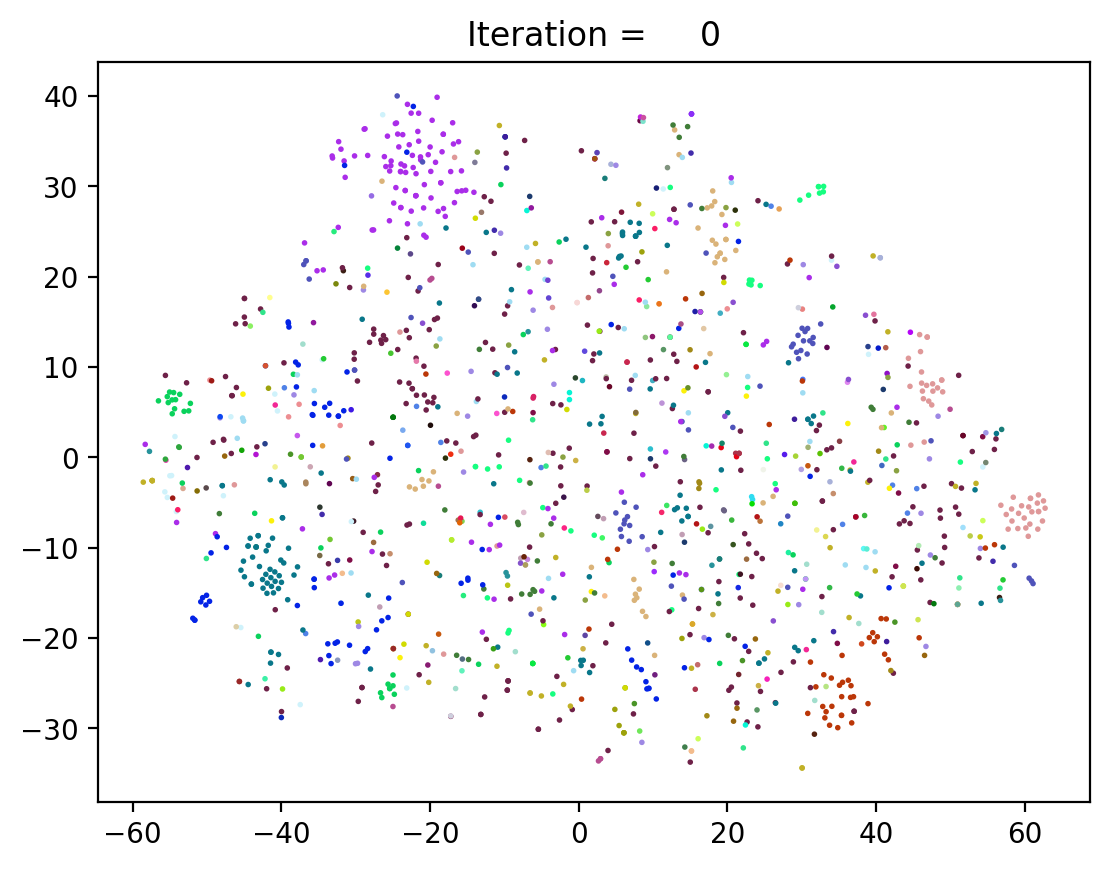

    0 --   7.26  --   7.28 --  0.052  


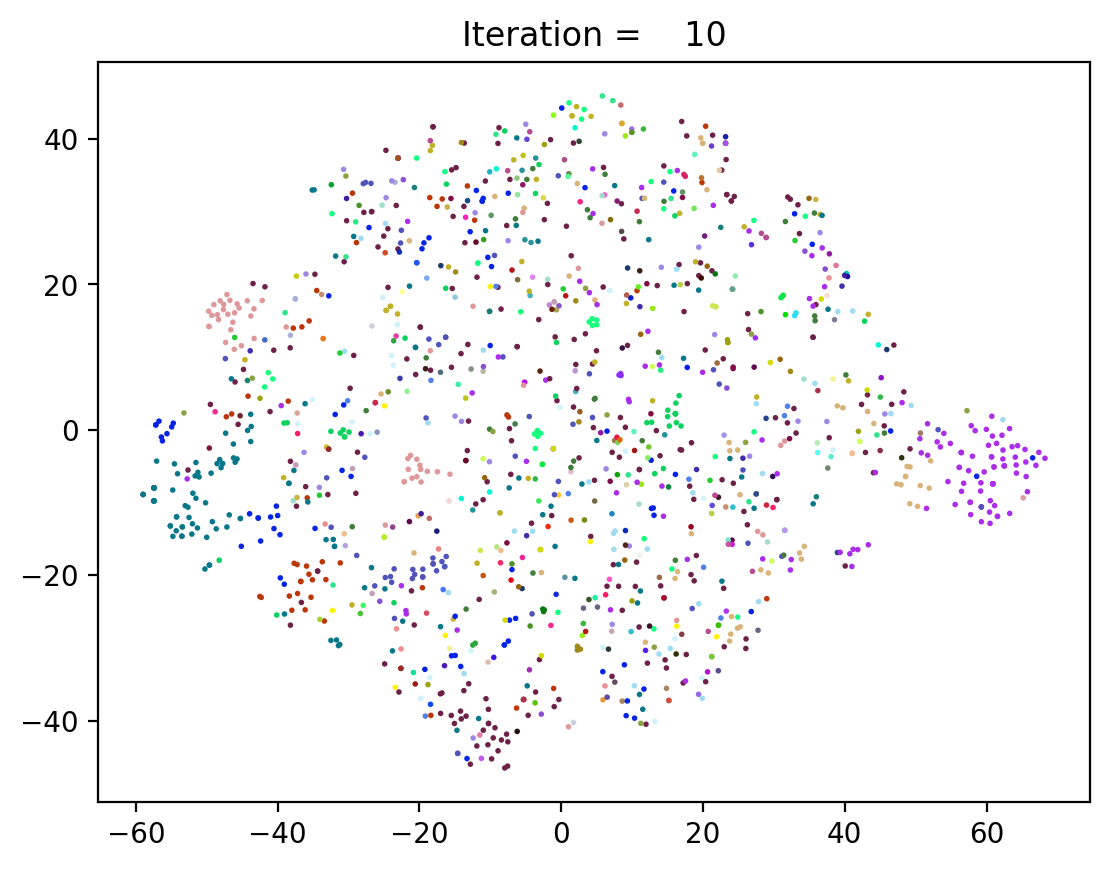

   10 --   7.14  --   7.23 --  0.058  


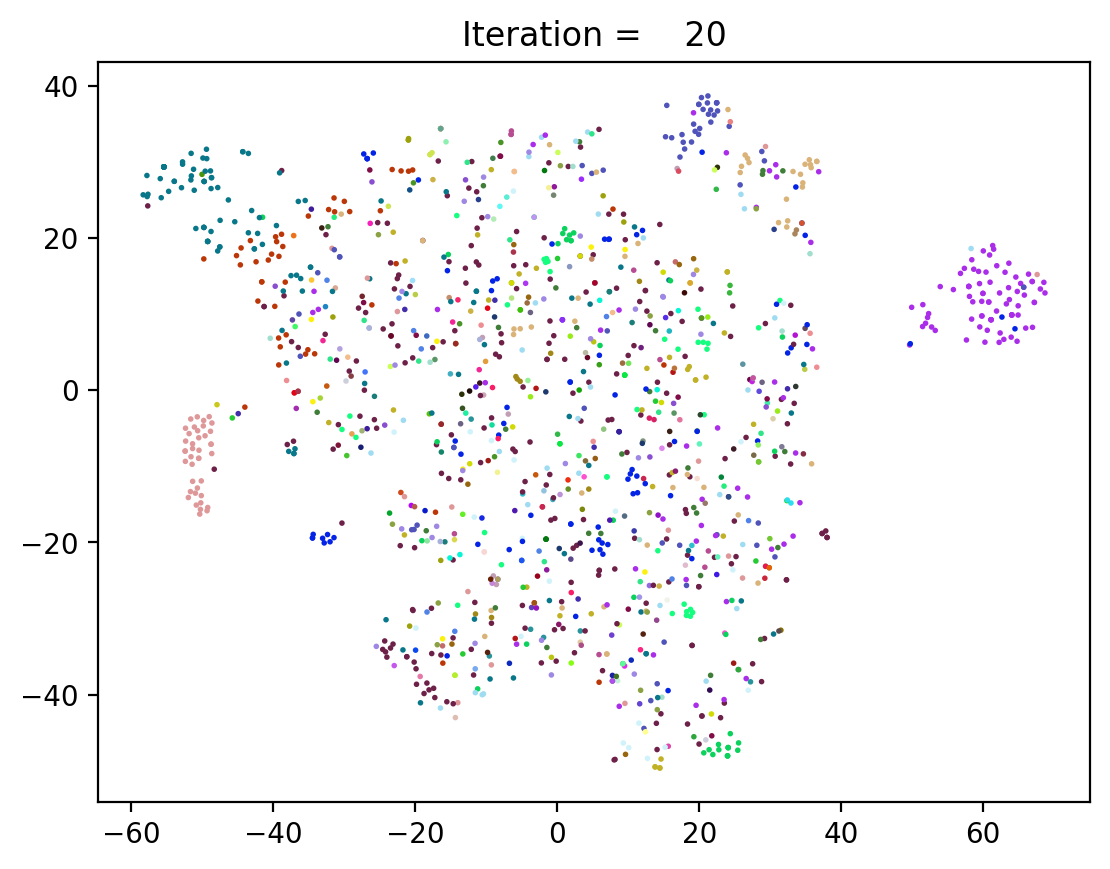

   20 --   6.83  --   7.01 --  0.078  
   30 --   6.53  --   6.90 --  0.136  


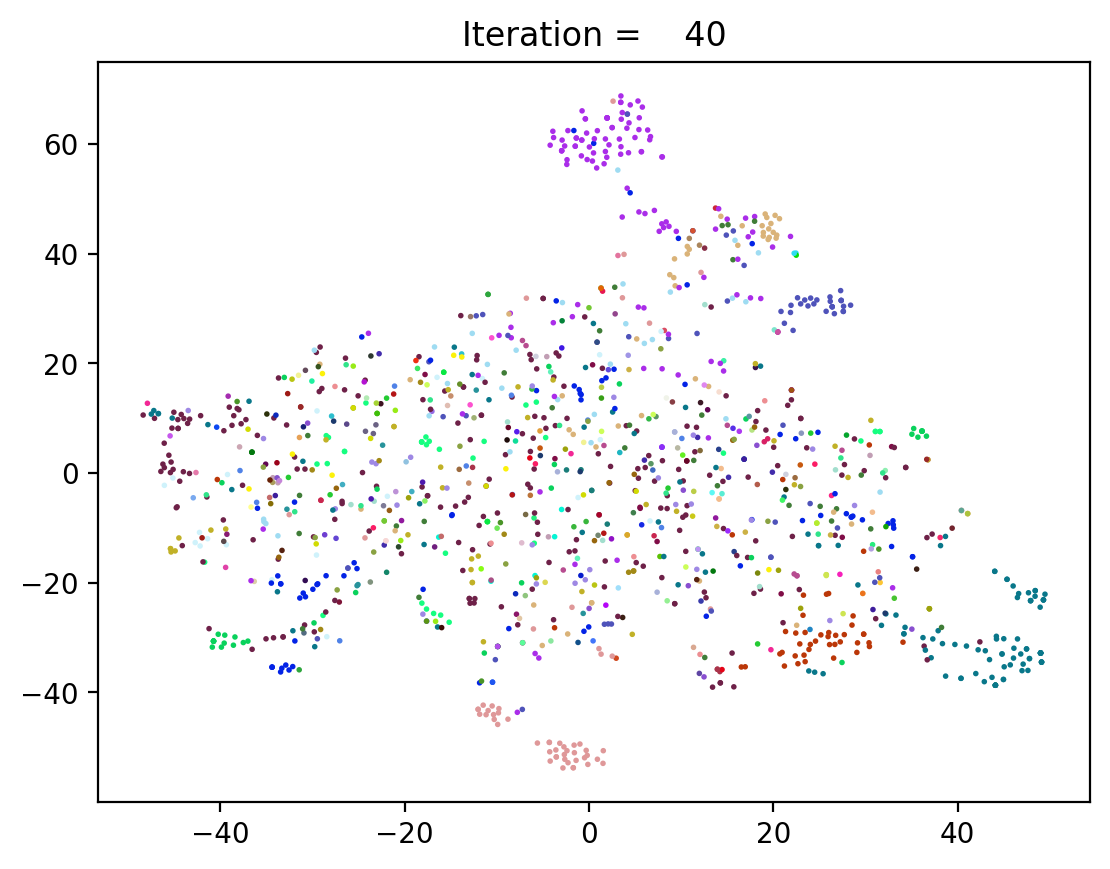

   40 --   6.24  --   6.88 --  0.160  
   50 --   5.89  --   6.82 --  0.168  
   60 --   5.62  --   6.96 --  0.177  


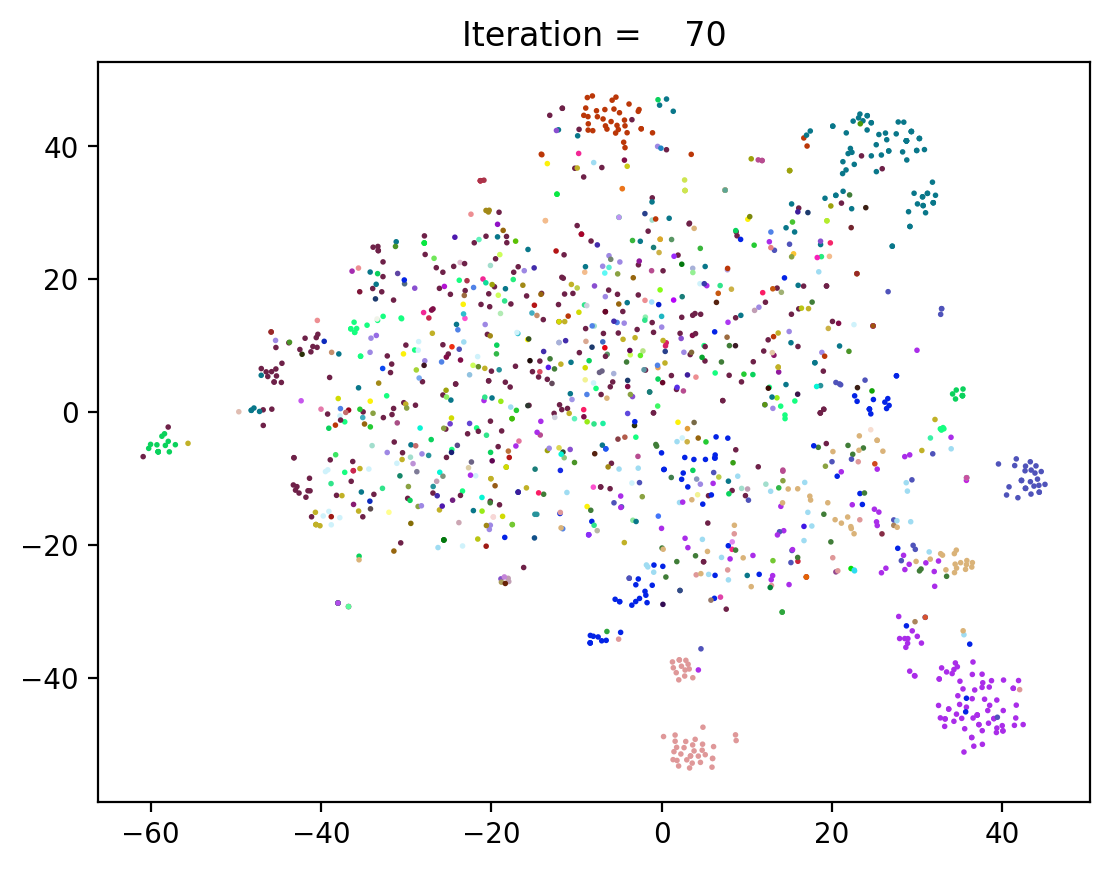

   70 --   5.28  --   6.90 --  0.195  
   80 --   4.94  --   7.12 --  0.212  
   90 --   4.67  --   7.17 --  0.225  


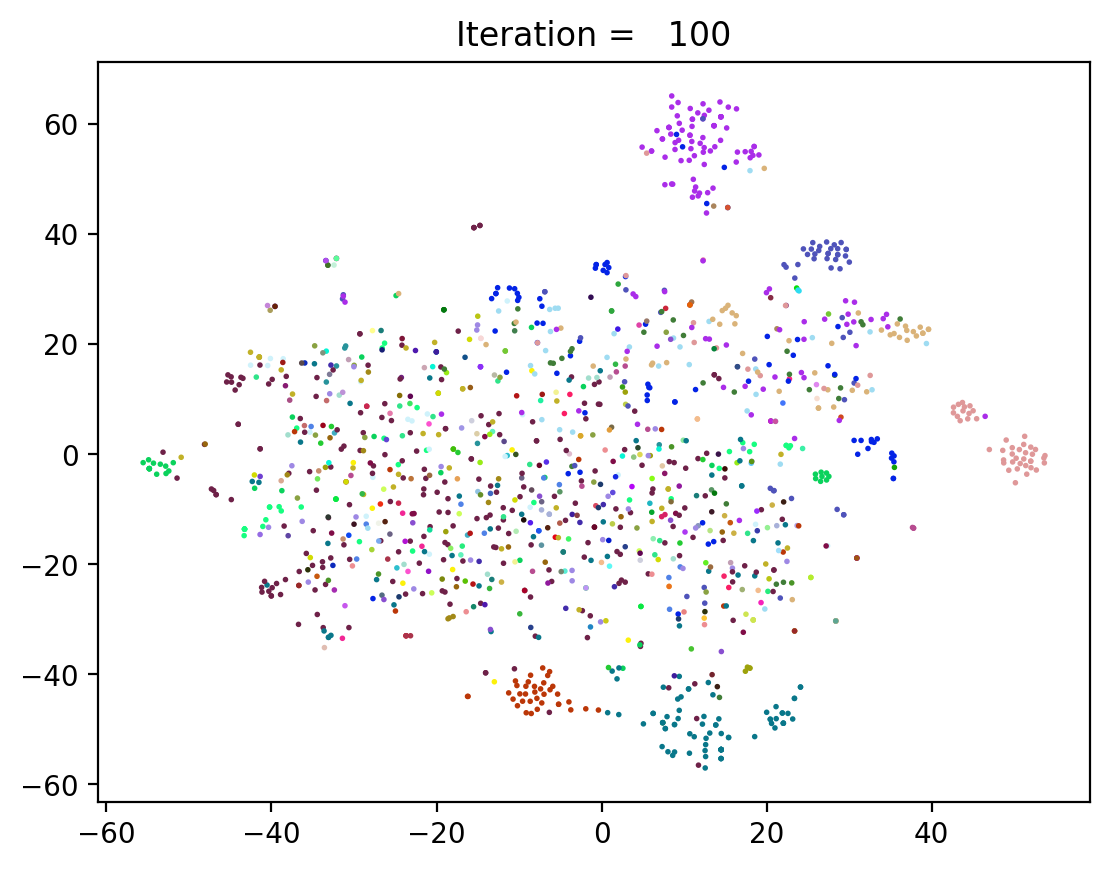

  100 --   4.32  --   7.41 --  0.233  
  110 --   4.03  --   7.80 --  0.243  
  120 --   3.69  --   7.91 --  0.251  
  130 --   3.41  --   8.07 --  0.275  
  140 --   3.09  --   8.62 --  0.281  
  150 --   2.81  --   8.91 --  0.280  
  160 --   2.62  --   9.68 --  0.280  
  170 --   2.41  --   9.52 --  0.302  
  180 --   2.14  --  10.37 --  0.293  
  190 --   1.99  --  10.64 --  0.283  


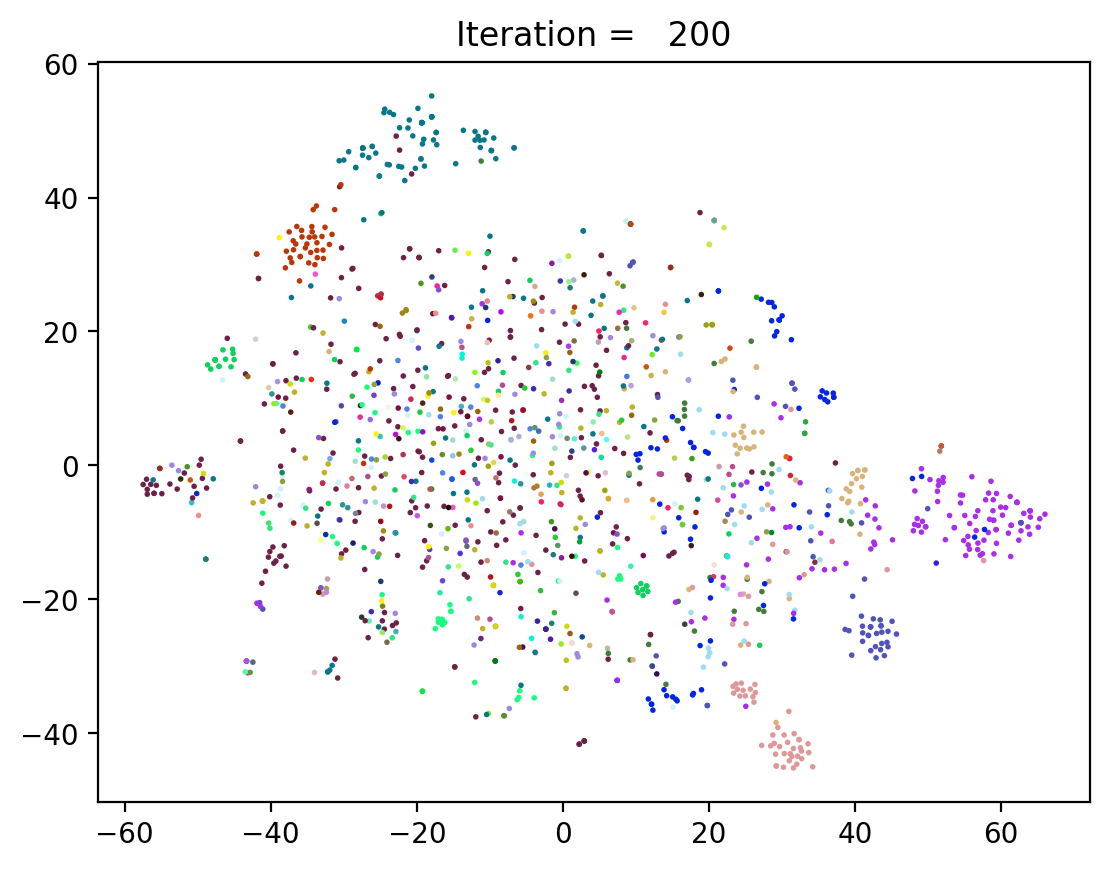

  200 --   1.86  --  10.76 --  0.297  
  210 --   1.69  --  11.19 --  0.313  
  220 --   1.62  --  11.48 --  0.304  
  230 --   1.55  --  11.25 --  0.328  
  240 --   1.48  --  11.44 --  0.326  
  250 --   1.36  --  11.41 --  0.326  
  260 --   1.32  --  11.47 --  0.339  
  270 --   1.29  --  11.66 --  0.332  
  280 --   1.25  --  11.78 --  0.346  
  290 --   1.22  --  11.90 --  0.344  


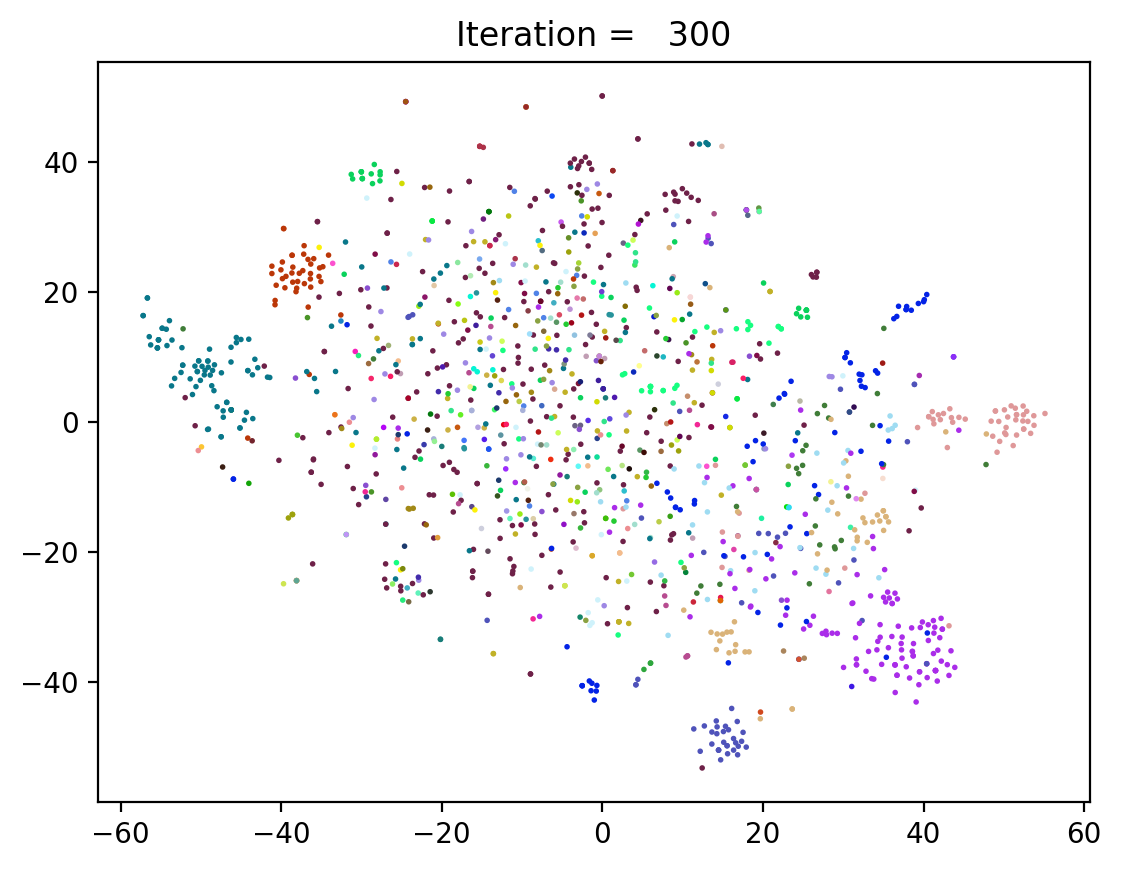

  300 --   1.17  --  11.78 --  0.343  
  310 --   1.15  --  11.77 --  0.358  
  320 --   1.15  --  11.86 --  0.364  
  330 --   1.12  --  11.98 --  0.360  
  340 --   1.09  --  11.88 --  0.361  
  350 --   1.10  --  12.03 --  0.359  
  360 --   1.05  --  12.08 --  0.366  
  370 --   1.04  --  12.06 --  0.374  
  380 --   1.04  --  12.00 --  0.371  
  390 --   1.03  --  12.04 --  0.357  


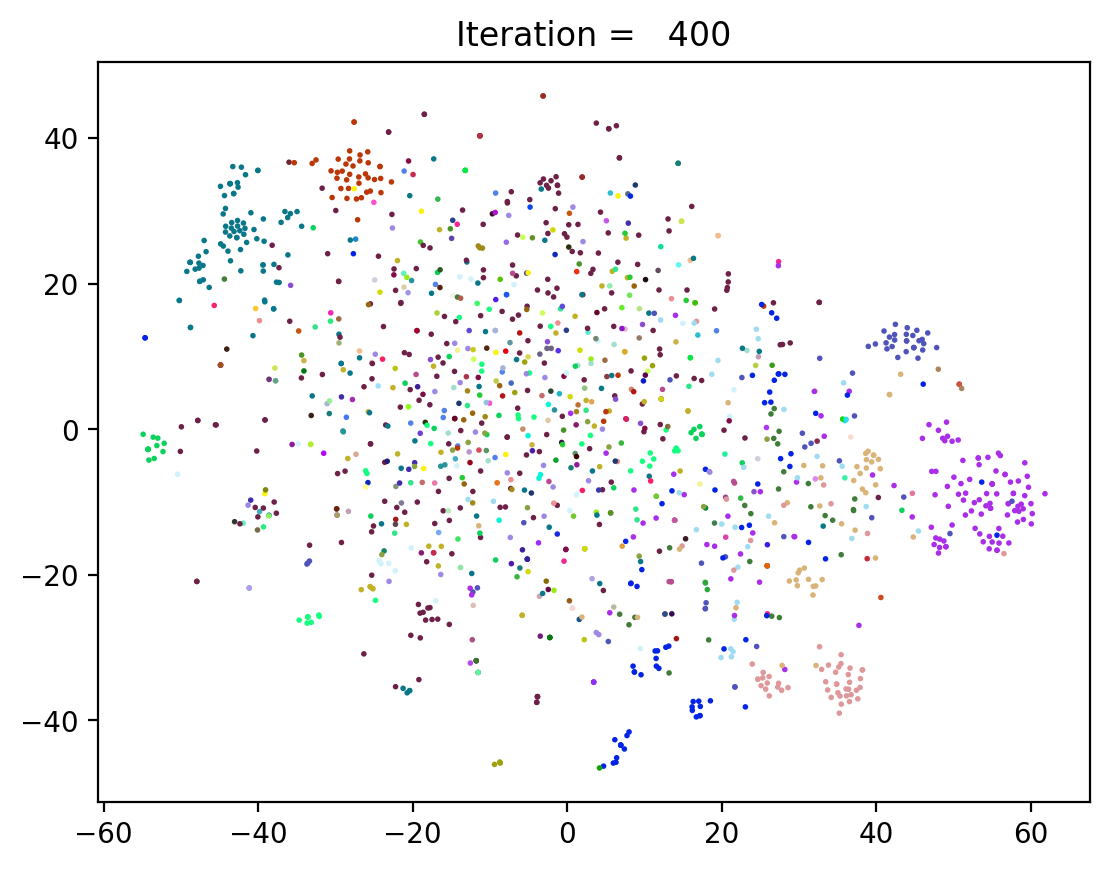

  400 --   1.03  --  12.05 --  0.365  
  410 --   1.01  --  12.00 --  0.376  
  420 --   1.00  --  11.87 --  0.377  
  430 --   1.02  --  12.02 --  0.377  
  440 --   1.02  --  11.85 --  0.376  
  450 --   0.99  --  11.85 --  0.378  
  460 --   1.00  --  12.15 --  0.380  
  470 --   0.98  --  11.89 --  0.378  
  480 --   0.99  --  11.97 --  0.381  
  490 --   0.98  --  11.85 --  0.381  


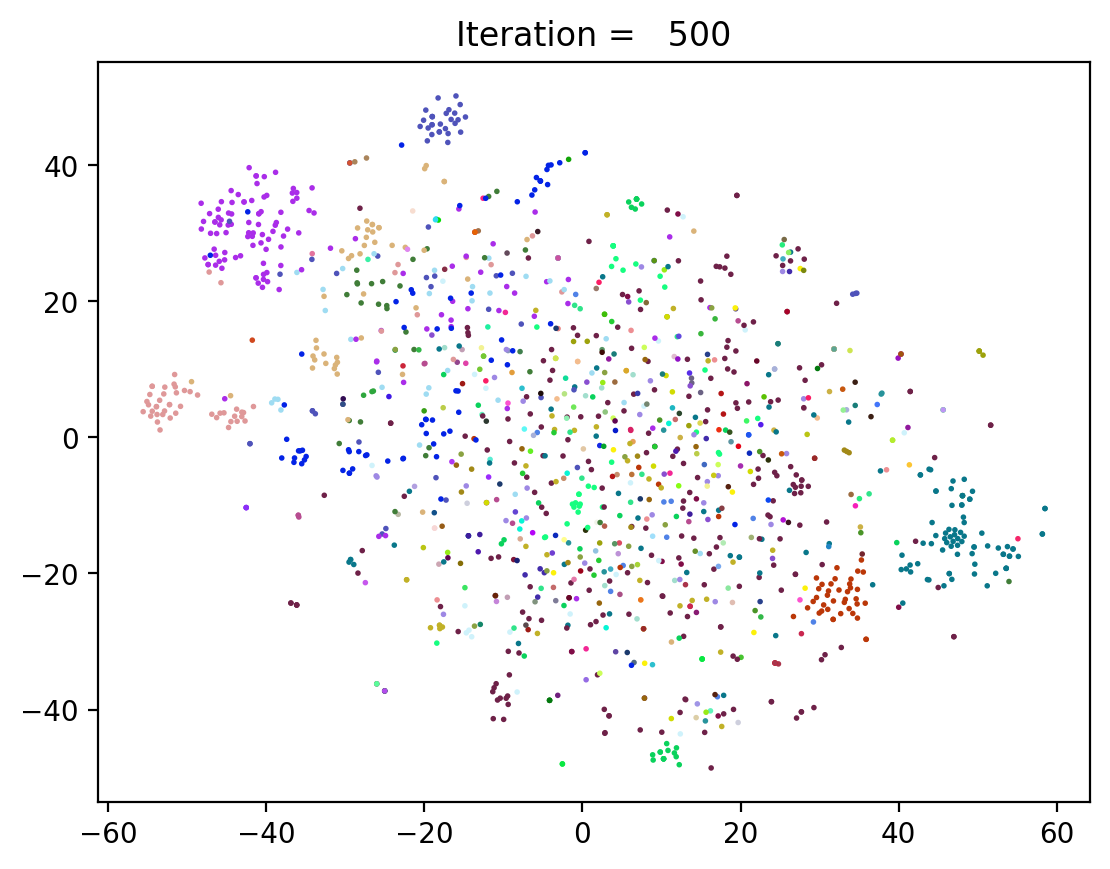

  500 --   0.95  --  11.77 --  0.385  
  510 --   0.96  --  11.84 --  0.384  
  520 --   0.96  --  11.81 --  0.385  
  530 --   0.95  --  11.84 --  0.383  
  540 --   0.95  --  11.86 --  0.378  
  550 --   0.96  --  11.80 --  0.376  
  560 --   0.93  --  11.78 --  0.389  
  570 --   0.95  --  11.80 --  0.385  
  580 --   0.93  --  11.77 --  0.394  
  590 --   0.94  --  11.87 --  0.387  


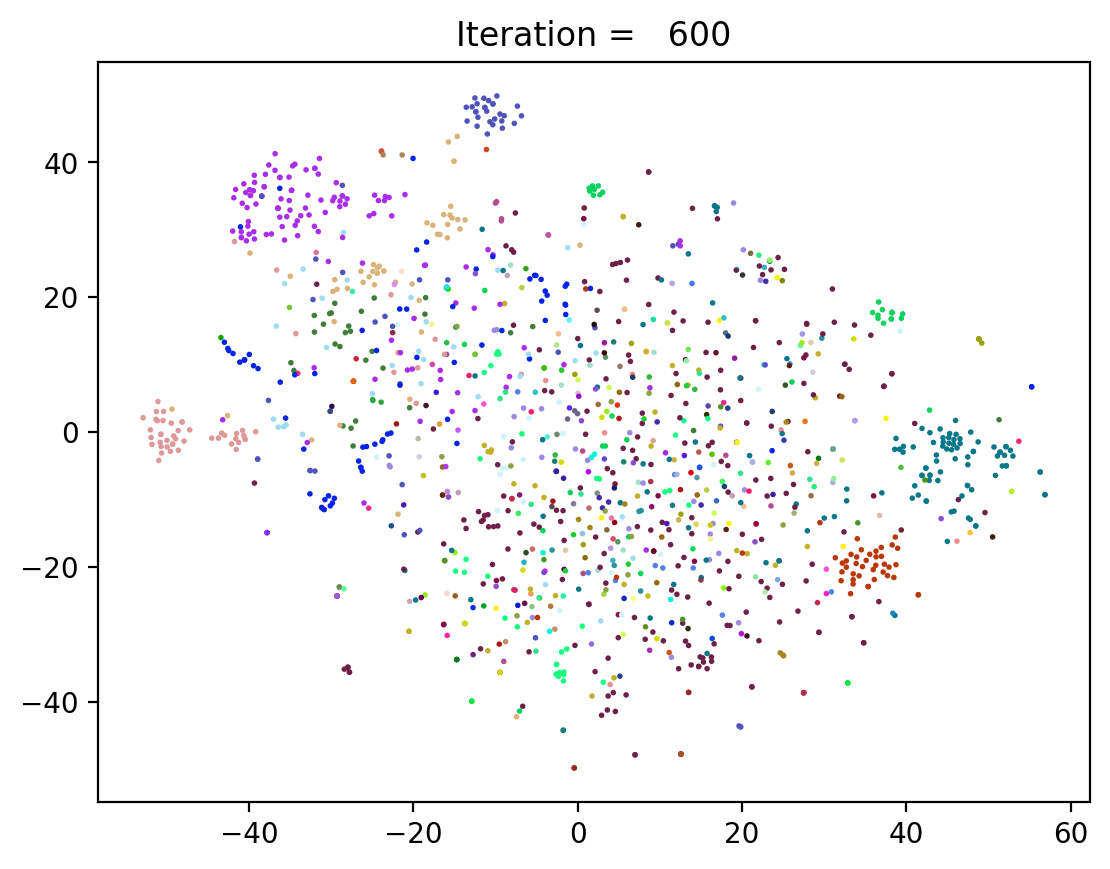

  600 --   0.91  --  12.05 --  0.379  
  610 --   0.92  --  11.93 --  0.387  
  620 --   0.92  --  11.80 --  0.382  
  630 --   0.92  --  11.77 --  0.396  
  640 --   0.92  --  11.59 --  0.389  
  650 --   0.90  --  11.68 --  0.389  
  660 --   0.91  --  11.71 --  0.385  
  670 --   0.92  --  11.71 --  0.386  
  680 --   0.90  --  11.66 --  0.397  
  690 --   0.91  --  11.72 --  0.389  


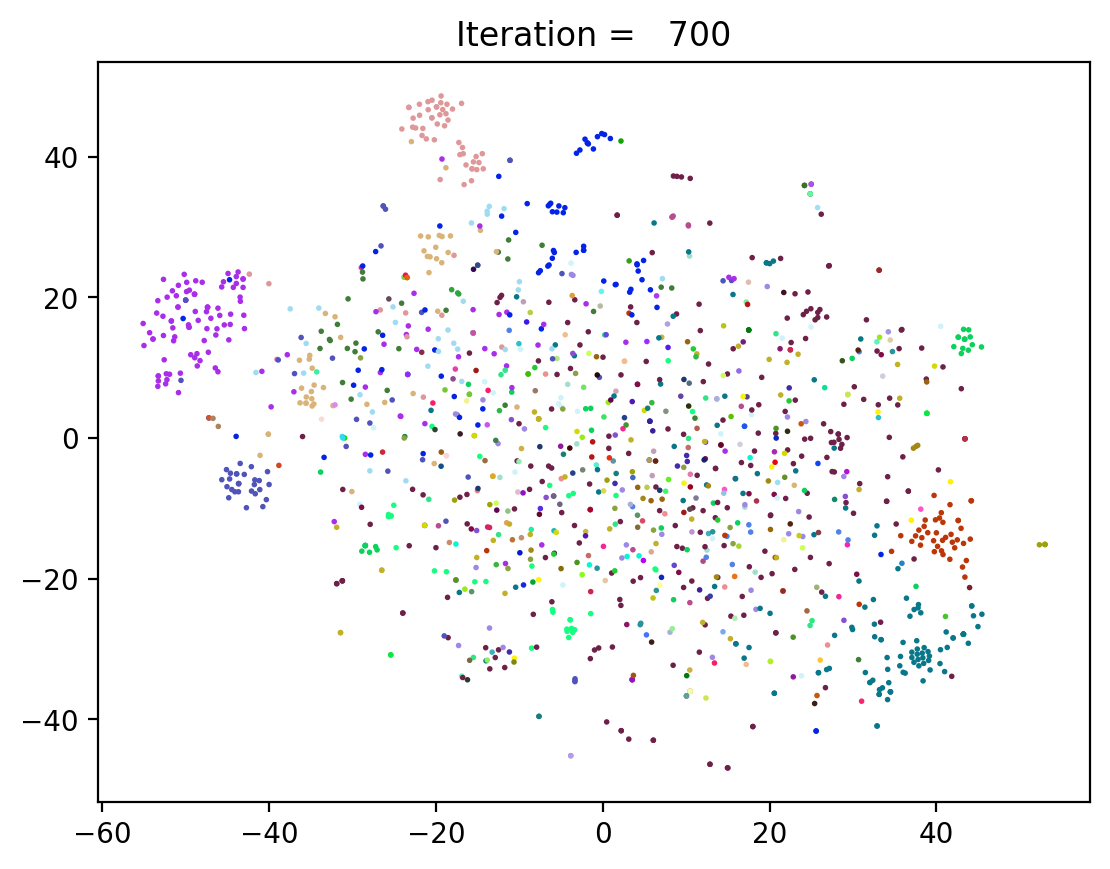

  700 --   0.90  --  11.63 --  0.389  
  710 --   0.88  --  11.71 --  0.392  
  720 --   0.89  --  11.67 --  0.395  
  730 --   0.89  --  11.70 --  0.391  
  740 --   0.89  --  11.80 --  0.394  
  750 --   0.90  --  11.81 --  0.392  
  760 --   0.90  --  11.51 --  0.391  
  770 --   0.88  --  11.59 --  0.396  
  780 --   0.89  --  11.63 --  0.399  
  790 --   0.89  --  11.76 --  0.394  


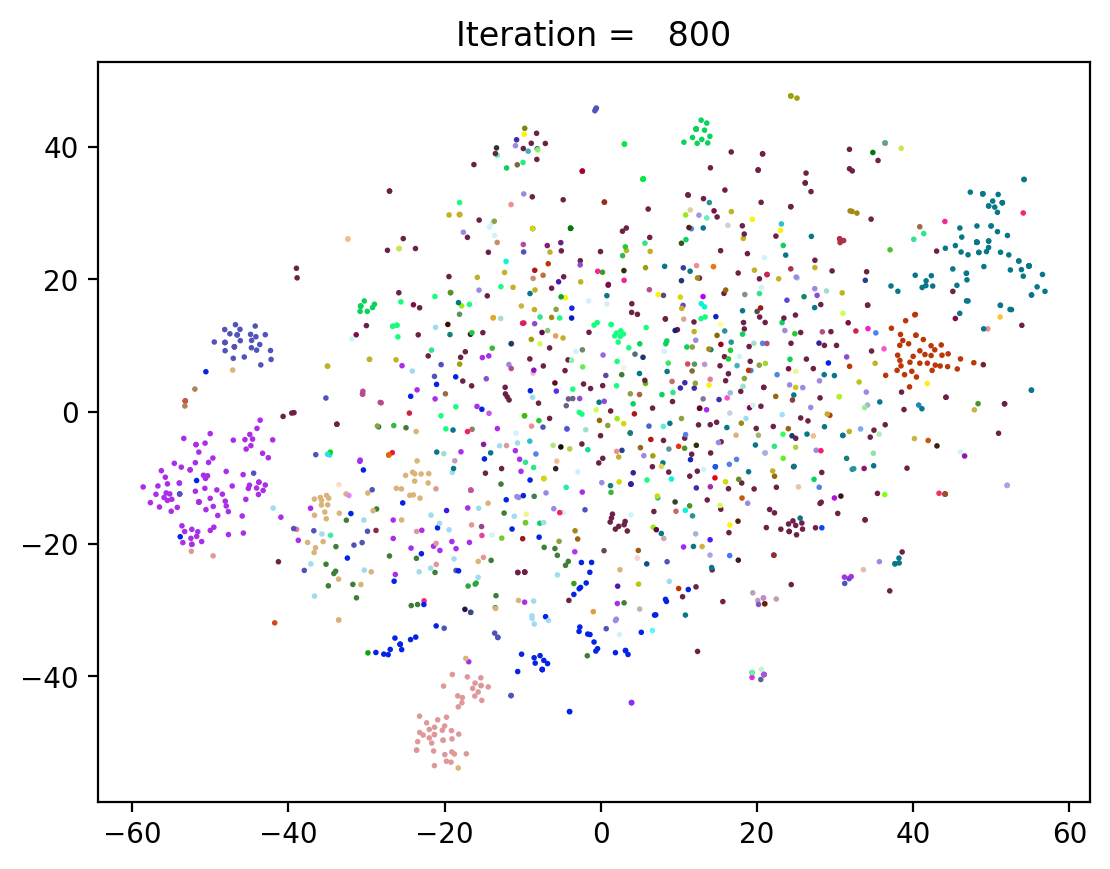

  800 --   0.88  --  11.68 --  0.400  
  810 --   0.89  --  11.50 --  0.389  
  820 --   0.89  --  11.47 --  0.396  
  830 --   0.88  --  11.53 --  0.403  
  840 --   0.87  --  11.43 --  0.395  
  850 --   0.88  --  11.59 --  0.399  
  860 --   0.88  --  11.40 --  0.402  
  870 --   0.88  --  11.50 --  0.402  
  880 --   0.87  --  11.34 --  0.398  
  890 --   0.87  --  11.48 --  0.399  


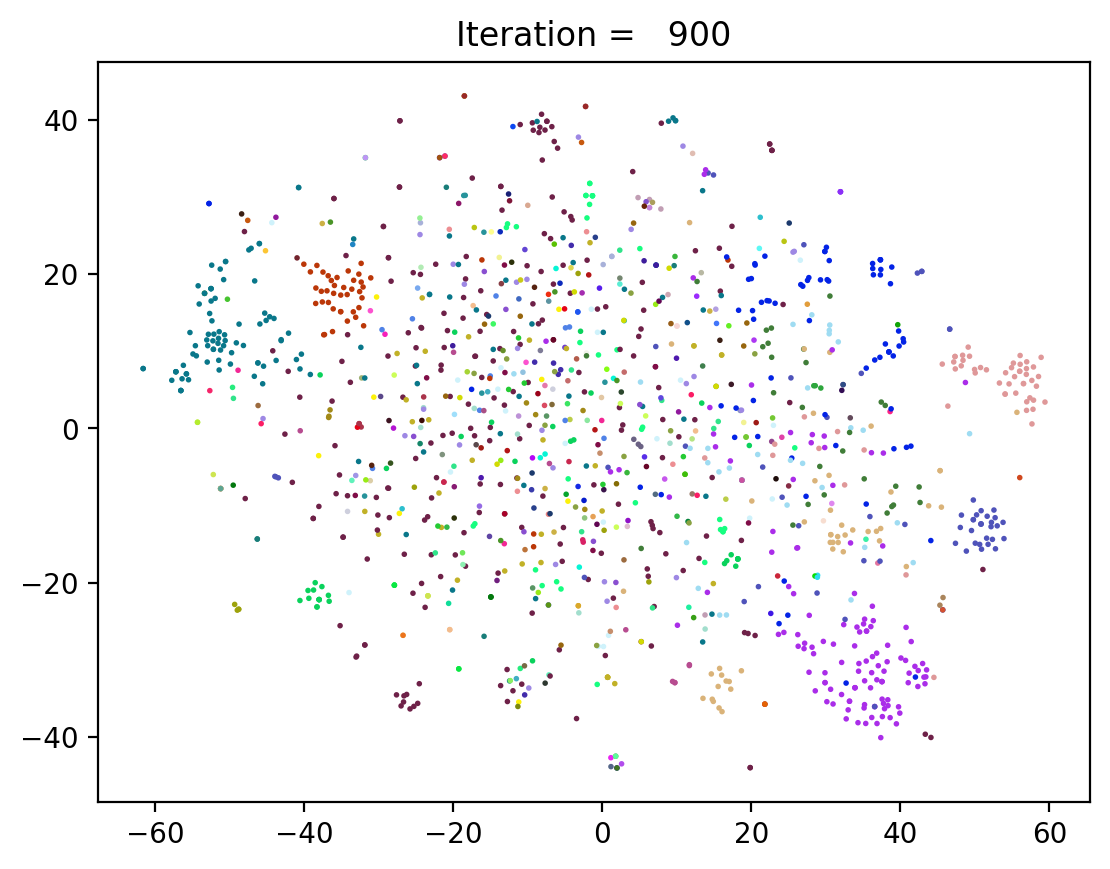

  900 --   0.87  --  11.53 --  0.394  
  910 --   0.87  --  11.52 --  0.397  
  920 --   0.87  --  11.53 --  0.405  
  930 --   0.86  --  11.44 --  0.399  
  940 --   0.86  --  11.53 --  0.400  
  950 --   0.87  --  11.45 --  0.404  
  960 --   0.87  --  11.39 --  0.397  
  970 --   0.87  --  11.50 --  0.402  
  980 --   0.85  --  11.51 --  0.407  
  990 --   0.86  --  11.57 --  0.402  


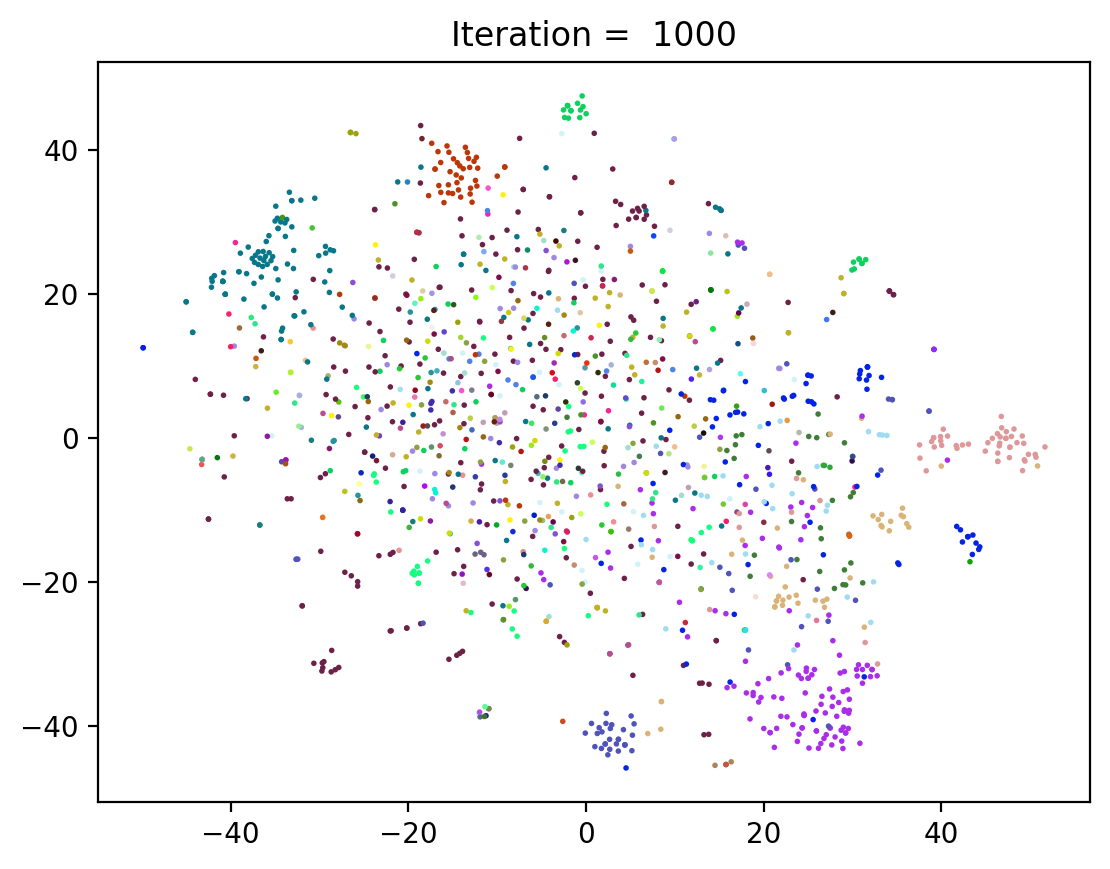

 1000 --   0.85  --  11.36 --  0.402  
 1010 --   0.86  --  11.35 --  0.402  
 1020 --   0.85  --  11.46 --  0.396  
 1030 --   0.86  --  11.42 --  0.400  
 1040 --   0.86  --  11.29 --  0.409  
 1050 --   0.85  --  11.43 --  0.406  
 1060 --   0.85  --  11.39 --  0.405  
 1070 --   0.85  --  11.44 --  0.404  
 1080 --   0.85  --  11.57 --  0.399  
 1090 --   0.85  --  11.37 --  0.403  


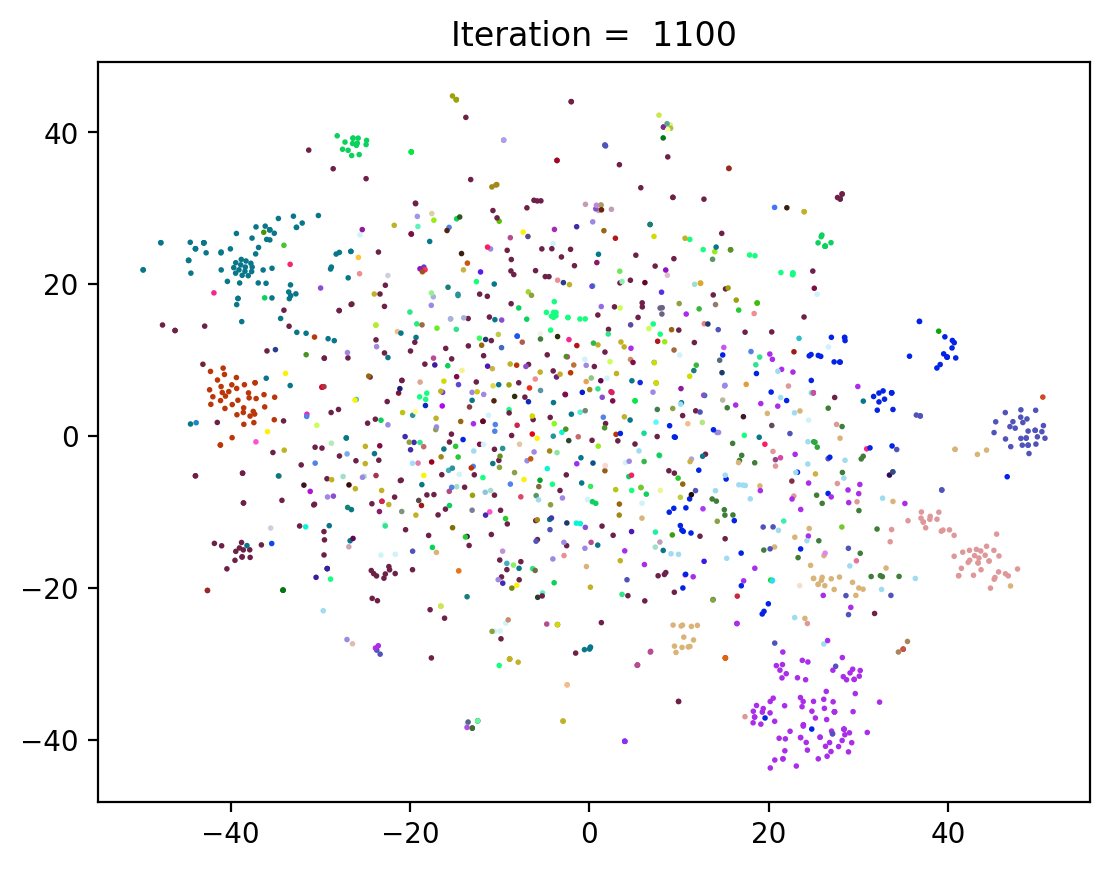

 1100 --   0.85  --  11.32 --  0.401  
 1110 --   0.85  --  11.50 --  0.407  
 1120 --   0.84  --  11.37 --  0.402  
 1130 --   0.85  --  11.51 --  0.403  
 1140 --   0.85  --  11.52 --  0.399  
 1150 --   0.85  --  11.43 --  0.407  
 1160 --   0.84  --  11.42 --  0.404  
 1170 --   0.84  --  11.35 --  0.399  
 1180 --   0.85  --  11.56 --  0.397  
 1190 --   0.84  --  11.46 --  0.401  


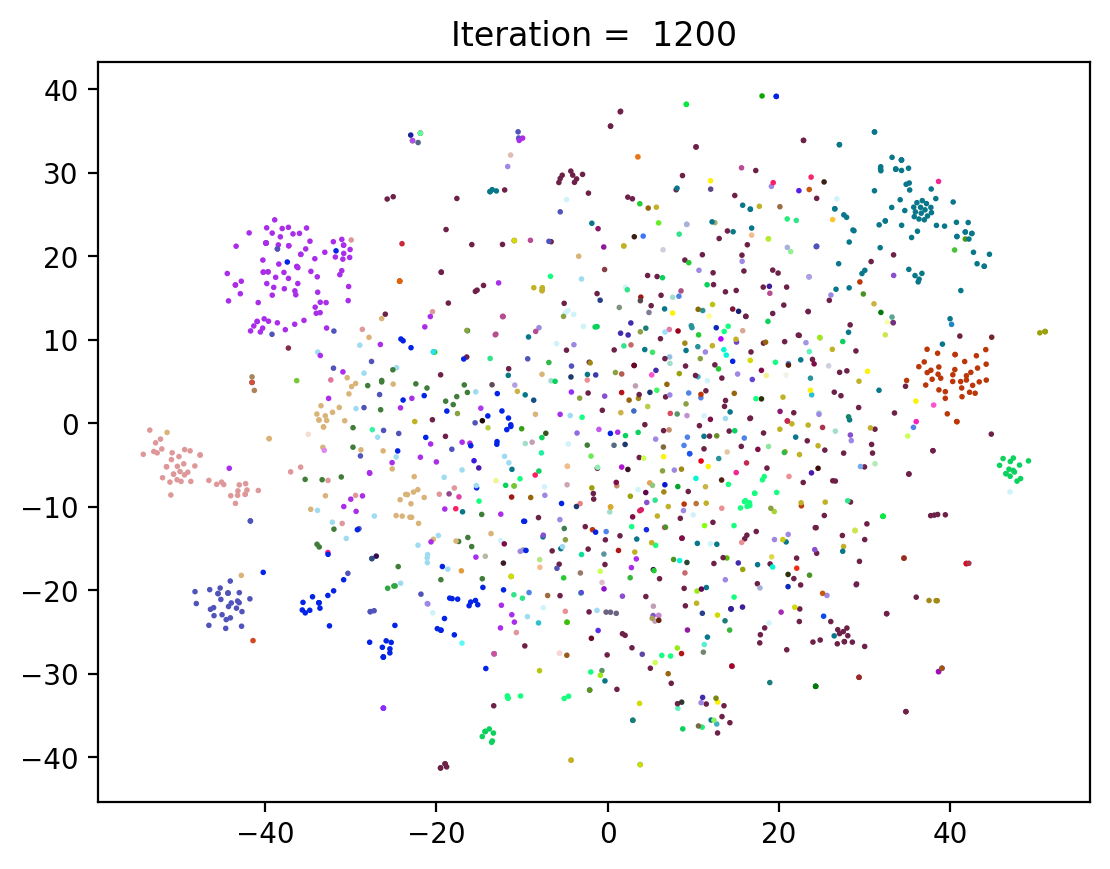

 1200 --   0.84  --  11.47 --  0.405  
 1210 --   0.85  --  11.36 --  0.403  
 1220 --   0.84  --  11.42 --  0.404  
 1230 --   0.84  --  11.35 --  0.404  
 1240 --   0.83  --  11.34 --  0.405  
 1250 --   0.85  --  11.35 --  0.405  
 1260 --   0.84  --  11.46 --  0.405  
 1270 --   0.83  --  11.45 --  0.406  
 1280 --   0.84  --  11.48 --  0.407  
 1290 --   0.84  --  11.40 --  0.407  


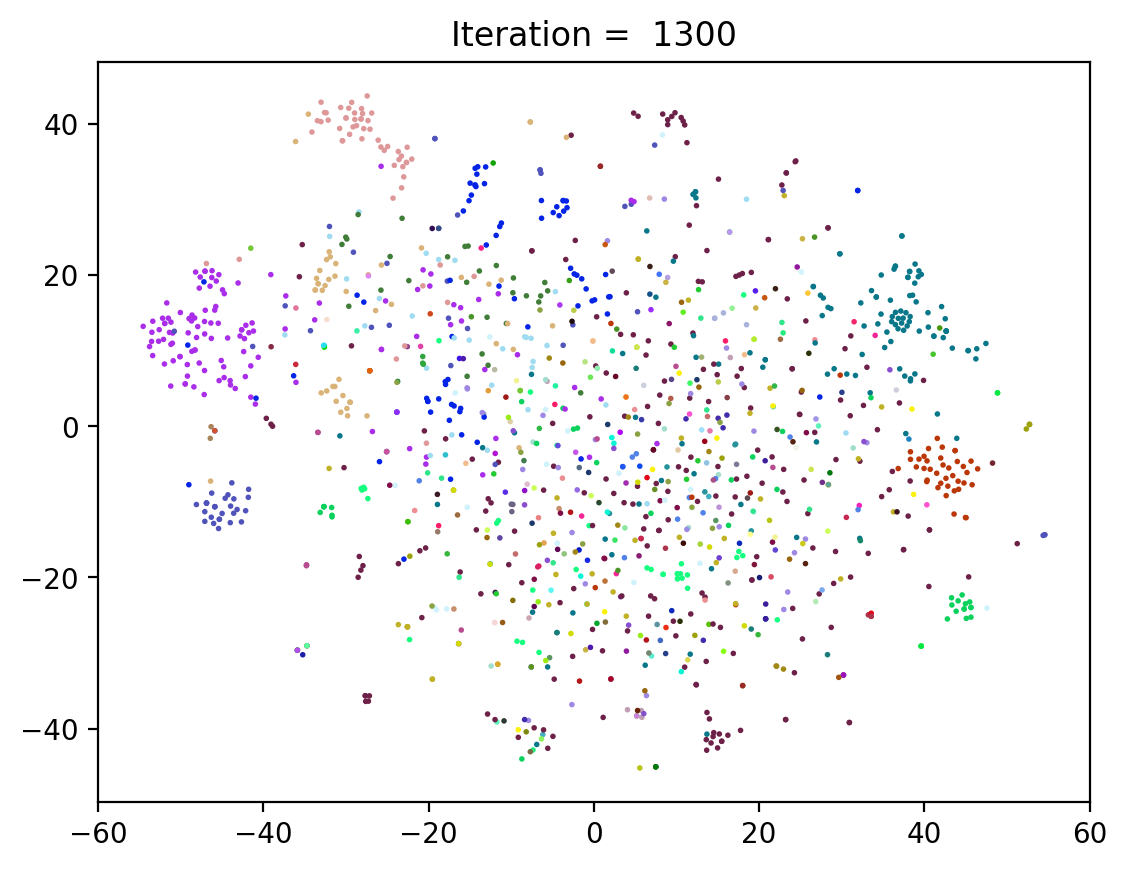

 1300 --   0.84  --  11.32 --  0.407  


KeyboardInterrupt: 

In [22]:
train_ids = np.arange(len(embs_tcra))[0::2]
test__ids = np.arange(len(embs_tcra))[1::2]

for iteration in range(2_200):
    if iteration % 10 == 0:
        with torch.no_grad():
            model.eval()
            # test__batch = np.random.choice(test__ids, 4096)
            test__batch = test__ids
            emb, _, test_loss, test_fraction = compute_loss(test__batch)
            if iteration % 100 == 0 or iteration in [10, 20, 40, 70]:
                visualize(emb, peptide_ids[test__batch])

    model.train()
    # train_batch = np.random.choice(train_ids, 4096)
    train_batch = train_ids
    _, _, train_loss, _ = compute_loss(train_batch)
    optim.zero_grad()
    train_loss.backward()
    optim.step()
    if iteration % 10 == 0:
        print(f'{iteration:>5} -- {train_loss:6.2f}  -- {test_loss:6.2f} -- {test_fraction:6.3f}  ')

In [23]:
def compute_loss_other(indices):
    left_emb = model(torch.from_numpy(embs_tcra[indices]).to(device))
    rght_emb = model(torch.from_numpy(embs_tcrb[indices]).to(device))
    pepts = peptide_ids[indices]

    logits = torch.einsum('i c, j c -> i j', left_emb, rght_emb)
    target = torch.arange(len(indices), device=device)
    loss_left = torch.nn.functional.cross_entropy(logits, target)
    loss_rght = torch.nn.functional.cross_entropy(logits.T, target)

    probs = (torch.softmax(logits, dim=0) + torch.softmax(logits, dim=1)) / 2

    _, pept_ids, n_recognized_counts = np.unique(pepts, return_inverse=True, return_counts=True)
    n_recognized = np.zeros(len(n_recognized_counts))
    for i in range(len(pept_ids)):
        n_recognized[pept_ids[i]] += probs[i, pept_ids == pept_ids[i]].sum()

    return left_emb + rght_emb, logits, (loss_left + loss_rght) * 0.5, n_recognized, n_recognized_counts

In [32]:
from copy import deepcopy
torch.save(model, 'model-1200-many-positives-in-single')
# model1 = deepcopy(model)

In [30]:
*_, nom, denom = compute_loss_other(test__ids)
order = np.argsort(denom)[::-1]

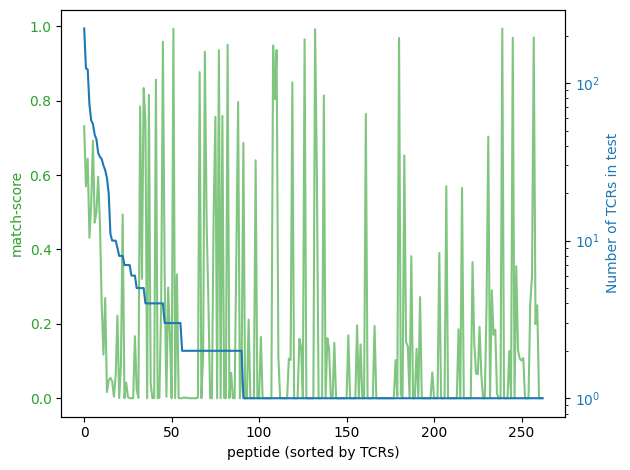

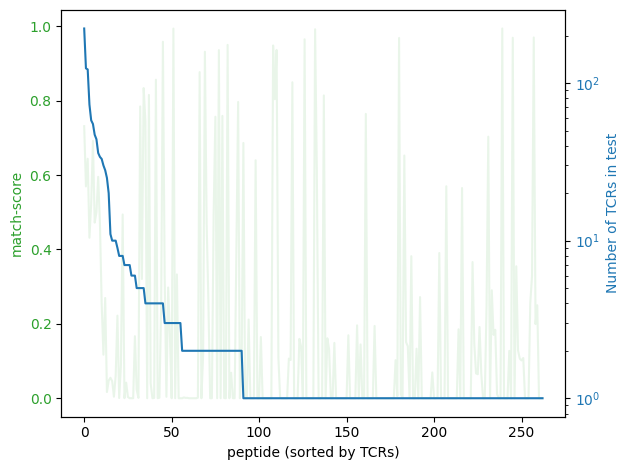

In [34]:
for alpha in [0.6, 0.1]:
    fig, ax1 = plt.subplots()
    
    color = 'tab:green'
    ax1.set_xlabel('peptide (sorted by TCRs)')
    ax1.set_ylabel('match-score', color=color)
    ax1.plot(
        (nom / denom)[order], color=color, alpha=alpha)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Number of TCRs in test', color=color)  # we already handled the x-label with ax1
    ax2.plot(
        denom[order], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.semilogy()
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()